In [10]:
import os
import sys
sys.path.append('../')
from catalogue_demo.constants import OPENAI_API_KEY
import utils
import pickle
import base64
import io
from flask import Flask, render_template

import openai
# import openai.ChatCompletion as ChatCompletion 
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
#summary imports
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredFileLoader


from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

#visualizations imports
import networkx as nx
import matplotlib.pyplot as plt


os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [7]:
%reload_ext autoreload
%autoreload 2

import importlib
from utils import *
from google_sheet import get_people_responses

In [19]:
top = Topic("Backpack")
responses = get_people_responses()
problems_str = ""
for response in responses:
    problems_str += response["problem"] + ', reporter is ' + response['email'] + "\n"

top.classify_problems(problems_str)


KeyError: 'Email Address'

In [9]:
# top.classify_exsisting_problems()

{'main_class': 'Size', 'sub_class': 'Pocket Size', 'description': 'The size of the small pocket in the front is too small and can barely contain a phone.'}
{'main_class': 'Functionality', 'sub_class': 'Zippers', 'description': "The zippers are getting stuck after a few uses of the backpack, and it's hard to open and close the backpack compartments."}
{'main_class': 'Waterproofing', 'sub_class': 'Internal Wetness', 'description': 'When I place the bag on something wet, it gets wet inside the bag and everything inside gets wet.'}


In [11]:
for i in range(len(top.problems)):
    top.create_challenge(i)

In [17]:
if top.challenges[0].get_solutions_str() == '':
    print("empty")

empty


 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [05/Nov/2023 12:21:37] "GET / HTTP/1.1" 200 -


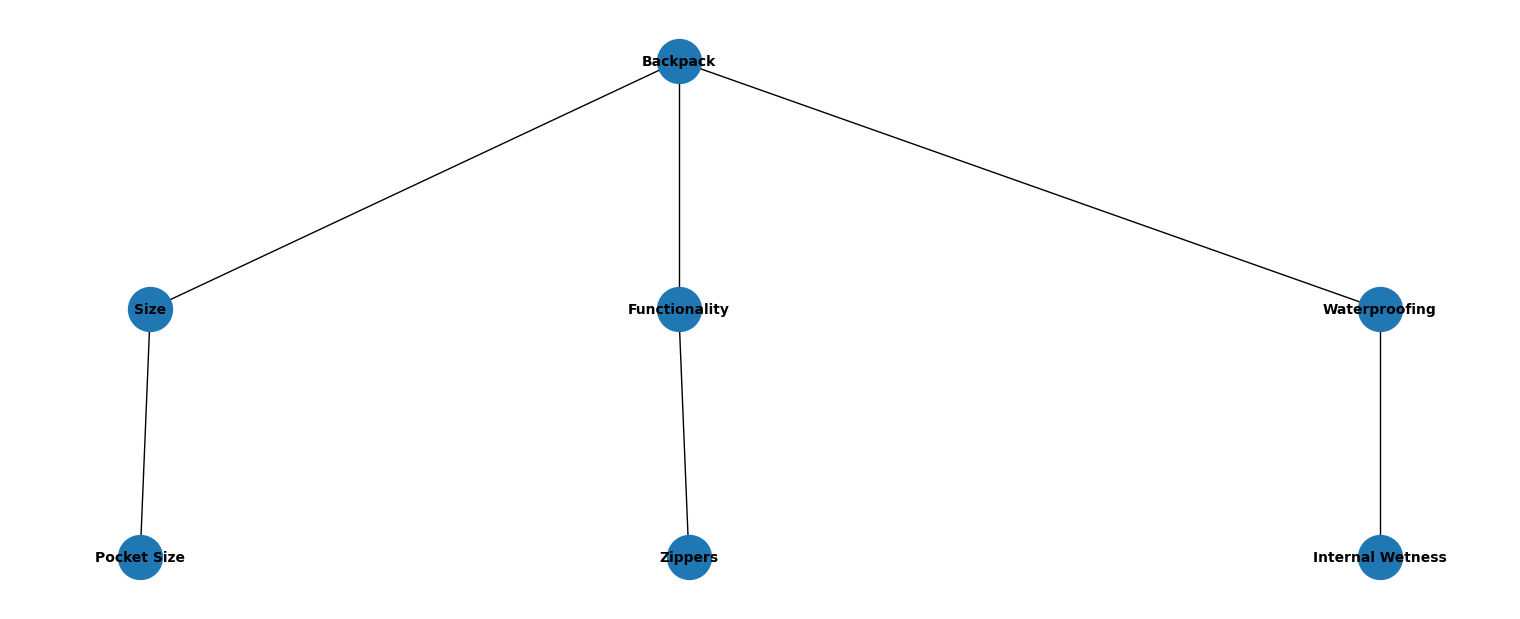

In [18]:
app = Flask(__name__)

@app.route('/')
def display_content():
    # Load data from your 'data.pickle' file
    topic_info, prob_str, prob_tree_plot, topic_challenges, sol_str, sol_tree_plot, sol_grades = load_data(top)

    return render_template('index.html',
                           topic_info=topic_info,
                           prob_str=prob_str,
                           prob_tree_plot=prob_tree_plot,
                           topic_challenges=topic_challenges,
                           sol_str=sol_str,
                           sol_tree_plot=sol_tree_plot,
                           sol_grades=sol_grades)

def load_data(top):
    # Load data from your 'data.pickle' file
    topic_info = ""
    prob_tree_plot = None
    topic_challenges = ""
    sol_tree_plot = None
    sol_grades = None

    # with open('data.pickle', 'rb') as file:
        # top = pickle.load(file)
    topic_info = "Topic is " + top.name + "\n"
    prob_str = top.get_problems_str()
    prob_tree_plot = plot_to_base64(top.plot_hierarchy_problems())
    
    if top.challenges == []:
        return topic_info, prob_str, prob_tree_plot, topic_challenges, "", None, None
    s1 = "\nWe look at 1 problem in particular and create from it a developed challenge. \n"
    topic_challenges = s1 + top.get_challenges_str()
    
    if top.challenges[0].solutions == []:
        return topic_info, prob_str, prob_tree_plot, topic_challenges, "", None, None
    s2 = "\nFrom that challenge, we create 3 optional solutions:\n"
    sol_str = s2 + top.challenges[0].get_solutions_str()
    sol_tree_plot = plot_to_base64(top.challenges[0].plot_hierarchy_solutions((10, 4)))
    sol_grades = plot_to_base64(top.challenges[0].plot_solutions_polygons(to_show=False))

    return topic_info, prob_str, prob_tree_plot, topic_challenges, sol_str, sol_tree_plot, sol_grades

def plot_to_base64(plt_obj):
    buffer = io.BytesIO()
    plt_obj.savefig(buffer, format='png')
    buffer.seek(0)
    plot_data = base64.b64encode(buffer.read()).decode()
    return plot_data

# run flask app
app.run()